In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import probit
import numpy as np

pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
plt.style.use('ggplot')

# Table of Contents

1. [Read Data](#Read-Data)
2. [Define Supporting Functions](#Define-Supporting-Functions)
3. [Cross-Sectional Regressions-Final screenshot](#Cross-Sectional-Regressions-Final-screenshot)
    1. [Includes Login](#Includes-Login)
    2. [Includes Careers Page](#Includes-Careers-Page)
    3. [Webpage Size](#Webpage-Size)
    4. [Number of A Tags](#Number-of-A-Tags)
4. [Difference in final screenshot and end year](#Difference-in-final-screenshot-and-end-year)
5. [Cross-Sectional Regression Table](#Cross-Sectional-Regression-Table)
6. [Growth regressions](#Growth-Regressions)
7. [Time Between Captures](#Time-Between-Captures)


In [122]:
## Read Data
html = pd.read_csv('../data/4_final_webpage_metadata.csv')

In [123]:
# Filter only clear successes and failures
html = html[html.ownershipstatus.isin(["Out of Business", "Publicly-held", "Acquired/Merged"])]

In [124]:
# Remove all webpages with size 0
html = html[html['website_size_kb'] != 0]

In [125]:
html["Failed"] = (html.ownershipstatus == "Out of Business").astype(int)

html["has_exit"] = (html["exit_date"].isna() == False).astype('int8')

html["end_yr"] = html["exit_date"].str.slice(start=0, stop=4) \
    .astype('float' ,errors='ignore') # This will have NAs

html["start_yr"] = html["startdate"].str.slice(start=0, stop=4). \
    fillna(html["lastVC"].str.slice(start=0, stop=4)) \
    .astype('float', errors='ignore')


html["lifespan"] = html["end_yr"] - html["start_yr"]
html.loc[html['Failed'] == 1, 'lifespan'] = pd.to_datetime(html.query('Failed == 1').lastVC).dt.year \
                                            - html.query('Failed == 1').start_yr + 2
# Convert website size and a_count to log format
html['websize_log'] = np.log(html['website_size_kb']).replace([-np.inf], 0)
html['a_log'] = np.log(html['a_count']).replace([-np.inf], 0)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [126]:
for i in range(1, 11):
    fColName = f"f_{i}"
    html[fColName] = ((html.lifespan <= i) & (html.Failed == 1)).astype('int')
    
for i in range(1, 11):
    sColName = f"s_{i}"
    html[sColName] = ((html.lifespan <= i) & (html.Failed == 0)).astype('int')

**The main dataset we'll using for regressions (for now):**

In [8]:
data = html.groupby('entityid').last()

## Define Supporting Functions

In [16]:
# This function plots the regressions for us. Takes in an independent variable of 
# interest (this will be plotted on the Y axis for better readbility), a control, 
# and options to plot industry individually and or/save
def plot_freg(y, data, control=None, industry=False, save=None):
    # Always do most basic OLS
    sns.regplot(x='Failed', y=y, data=data, x_estimator=np.mean, color='g', label='Base OLS')
    
    if not industry:
        sns.regplot(x='Failed', y=y, data=data, x_estimator=np.mean, y_partial=control, \
                    color='b', label=f'Controlling for {control}');
        plt.legend()
    else:
        ind_groups = data.groupby('new_industrygroup')
        for name, group in ind_groups:
            # We're gonna ignore these industries for now
            ind_ignore = ["To Be Assigned", "Energy and Utilities", "Industrial Goods and Materials"]
            if name not in ind_ignore:
                sns.regplot(x='Failed', y=y, data=group, x_estimator=np.mean, y_partial=control, label=name);
        if control:
            plt.title(f'Predicting failure on {y} by industry, controlling for {control}')
        else:
            plt.title(f'Predicting failure on {y} by industry')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
    plt.xticks([0,1])
    if save:
        plt.savefig(save, dpi=200, bbox_inches='tight')

In [152]:
def run_model(x, control=['end_yr', 'new_industrygroup', 'state', 'start_yr'], lifespanControl=None, data=data):
    
    if lifespanControl is not None:
        data.query('lifespan <= @lifespanControl')
    
    X = data[x]
    
    
    for i in control:
        if data[i].nunique() < 100:
            i_dummies = pd.get_dummies(data[i], prefix=i, drop_first=True)
            X = pd.concat([X, i_dummies], axis=1)
    X = sm.add_constant(X)
    mod = sm.OLS(data['Failed'], X).fit()
    return mod

## Cross-Sectional Regressions-Final screenshot

### Includes Login

In [ ]:
run_model('login').summary()

**Controlling for end year**

In [ ]:
run_model('login', control=['end_yr']).summary()

In [ ]:
plot_freg('login', data=data, control='end_yr', save='login_basic.png')

**Control for industry _and_ end year**

In [ ]:
run_model('login', control=['end_yr', 'new_industrygroup']).summary()

In [ ]:
plot_freg('login', data=data, control='end_yr', industry=True)

### Includes Careers Page

In [ ]:
run_model('careers').summary()

**Controlling for end year**

In [ ]:
run_model('careers', control=['end_yr']).summary()

**Control for end year and industry**

In [ ]:
run_model('careers', control=['end_yr']).rsquared

In [ ]:
run_model('careers', control=['new_industrygroup', 'end_yr']).summary()

**Plot**

In [ ]:
plot_freg('careers', data, 'end_yr')

**Plot for industry**

In [ ]:
plot_freg('careers', data, industry=True, save='industry_graph_simple.png')

**Plot for industry, controlling for end year**

In [ ]:
plot_freg('careers', data, control='end_yr', industry=True, save='careers_complex.png')

### Webpage Size

Setup

In [ ]:
# Check out distribution
sns.kdeplot(data['websize_log'], color='b', fill='b');

**OLS Regression**

In [ ]:
run_model('websize_log').summary()

**Control for year**

In [ ]:
run_model('websize_log', control=['capture_yr']).rsquared

**Control for industry**

In [ ]:
run_model('websize_log', control=['new_industrygroup']).rsquared

**Plot, controlling for end year**

In [ ]:
plot_freg('websize_log', data, control='end_yr')

**Industry Plot**

In [ ]:
plot_freg('websize_log', data, industry=True)

**Plot for industry, controlling for capture year**

In [ ]:
plot_freg('websize_log', data, control='capture_yr', industry=True, save='websize_log_ind_ey.png')

### Number of A Tags

In [ ]:
run_model('a_count', control=['end_yr']).summary()

## Difference in final screenshot and end year

This is somewhat promising...maybe we couldchange this to a more precise number by including month too?

In [ ]:
data['finalsnap_end_diff'] = data['end_yr'] - data['capture_yr']

In [ ]:
sns.kdeplot(data=data, x='finalsnap_end_diff', hue='Failed', palette=['b', 'r'], fill=True);

In [ ]:
data[data.Failed == 1].finalsnap_end_diff.describe()

In [ ]:
data[data.Failed == 0].finalsnap_end_diff.describe()

In [ ]:
run_model('finalsnap_end_diff', control=['new_industrygroup']).pvalues

In [ ]:
plot_freg('finalsnap_end_diff', data, industry=True, save='endDiff.png')

## Cross-Sectional Regression Table

Create empty DataFrame

In [ ]:
reg_results = pd.DataFrame(columns=['X', 'Y', 'Coefficient', 'Control', 'T', 'PValue', 'RSquared'])

In [ ]:
data.columns

Define columns to run regressions on

In [ ]:
cols_of_interest = [i for i in data.select_dtypes(include='number') if i not in ['Failed', 'has_exit']]

In [ ]:
data['a_log'].describe()

In [ ]:
for i in cols_of_interest:
    print(i)
    mod = run_model(i)
    results = {
        'X': i,
        'Y': 'Failed',
        'Coefficient': mod.params[i],
        'Control': "",
        'T': mod.tvalues[i],
        'PValue': mod.pvalues[i],
        'RSquared': mod.rsquared,
    }
    reg_results = reg_results.append(results, ignore_index=True)
    # Control for end year, industry, state, and start year
    mod = run_model(i, control=['end_yr', 'new_industrygroup', 'state', 'start_yr'])
    results['Coefficient'] = mod.params[i]
    results['PValue'] =  mod.pvalues[i]
    results['RSquared'] = mod.rsquared
    results['Control'] = 'End Year, Industry, State, Year founded'
    reg_results = reg_results.append(results, ignore_index=True)

Convert R-Squared out of scientific notation

In [ ]:
reg_results['RSquared'] = reg_results['RSquared'].astype('float64')
reg_results['RSquared'] = np.round(reg_results['RSquared'], 4)

In [ ]:
reg_results.name = 'Last screenshot cross-sectional regressions'

Sort by R-Squared

In [ ]:
reg_results.sort_values('RSquared', ascending=False).reset_index(drop=True).head(15)

## Growth Regressions

**Setup**

Add these growth columns for every column that we care about

In [6]:
g_cols_of_interest = ['website_size_kb', 'careers', 'blog', 'login', 'contact',
       'team', 'about', 'news', 'faq', 'call_to_action', 'testimonial',
       'title', 'description', 'keywords', 'p_count', 'h_count', 'img_count',
       'a_count', 'table_count', 'form_count', 'script_count']
binCols =  ['careers', 'blog', 'login', 'contact',
       'team', 'about', 'news', 'faq', 'call_to_action', 'testimonial',
       'title', 'description', 'keywords']

Calculate Percentage Difference

In [7]:
def find_last_diff(x, col, start, end, isBin):
    if len(x.index) > end:
        start_val = x.iloc[start][col]
        end_val = x.iloc[end][col]
        diff = end_val - start_val
        if isBin and diff == 1:
            diff = 100
        if start_val == 0:
            diff = (((end_val + 1) - (start_val + 1)) / (start_val + 1)) * 100
        else:
            diff = ((end_val - start_val) / start_val) * 100
        return diff
    return None

Add the column to the HTML DataFrame

In [8]:
def add_last_growth_col(col, colName, start, end):
    s = html.groupby('entityid').apply(lambda x: find_last_diff(x, col, start, end, isBin=(col in binCols)))
    s.name = colName
    return html.merge(s, on='entityid')

Add ALL of the columns to the HTML DataFrame

In [146]:
def create_growth_cols(start, end):
    global html
    for i in g_cols_of_interest:
        print(i)
        colName = f"g{start}{end}_{i}"
        html = add_last_growth_col(col=i, colName=colName, start=0, end=3)

Run regressions on the growth columns and return a table containing all the important info about the regressions

In [143]:
def growth_reg(start, end, lifespanControl=None):
    growth_reg_results = pd.DataFrame(columns=['X', 'Y', 'Coefficient', 'Control', 'T', 'PValue', 'RSquared'])    

    for i in g_cols_of_interest:
        i = f"g{start}{end}_{i}"
        
        # Control for end year, industry, state, and start year
        mod = run_model(i, control=['end_yr', 'new_industrygroup', 'state', 'start_yr'], lifespanControl=lifespanControl)
        
        results = {
            'X': i,
            'Y': 'Failed',
            'Coefficient': mod.params[i],
            'Control': 'End Year, Industry, State, Year founded',
            'T': mod.tvalues[i],
            'PValue': mod.pvalues[i],
            'RSquared': mod.rsquared
        }
        
        growth_reg_results = growth_reg_results.append(results, ignore_index=True)
        

    # Convert Rsquared to float
    growth_reg_results['RSquared'] = growth_reg_results['RSquared'].astype('float64')
    growth_reg_results['RSquared'] = np.round(growth_reg_results['RSquared'], 4)
    
    # Set name
    growth_reg_results.set_camption = f"% Growth from years {start} to {end}"
    
    return growth_reg_results

Setup

In [11]:
start = 1
end = 3
lifespanControl = 5

**Example doing the y dummy variables**

Note: end_yr isn't accurate (for what we want to be)...
Therefore, "lifespan", for what we measure it as (end_yr - start_yr), is not accurate

Let's try doing it with lastVC

This is why it's so innacurate:

Let's also compare it with their start dates

New problem found: We don't have a precise "failed" date for failed companies

Reset lifespan for Failed

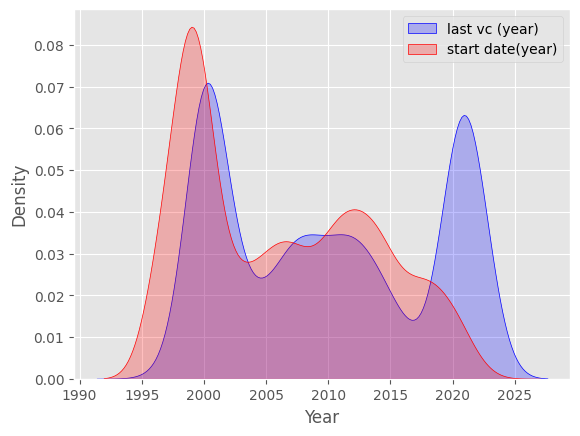

In [111]:
sns.kdeplot(pd.to_datetime(data.query('Failed == 1').lastVC) \
    .dt.year, \
    color='b', fill='b', label='last vc (year)');
sns.kdeplot(data.query('Failed == 1').start_yr, color='r', fill='b', label='start date(year)');
plt.xlabel('Year')
plt.legend();

In [94]:
data.loc[data['Failed'] == 1, 'lifespan'].describe()

count    4687.000000
mean        5.946661
std         4.104292
min         2.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        27.000000
Name: lifespan, dtype: float64

Now, run the regressions. First, create the y-variable, which is failed within 5 years of the founding date.

Let's just test this out by predicting on whether the *third* screenshot has an image or not...

So, interpreting this would mean...
for every additional `<img>` tag, a websites probaility that it has failed or succeeded within `[1-10]` years goes up or decreases by some amount...

In [151]:
data = html.groupby('entityid').nth(3)

In [133]:
data.columns

Index(['yr_from_start', 'capture_yr', 'capture_m', 'file_path', 'file_exists',
       'website_size_kb', 'careers', 'blog', 'login', 'contact', 'team',
       'about', 'news', 'faq', 'call_to_action', 'testimonial', 'title',
       'description', 'keywords', 'p_count', 'h_count', 'img_count', 'a_count',
       'table_count', 'form_count', 'script_count', 'entityname',
       'new_industrygroup', 'state', 'weburl', 'pb_companyid', 'startdate',
       'lastVC', 'ownershipstatus', 'exit_date', 'Failed', 'has_exit',
       'end_yr', 'start_yr', 'lifespan', 'websize_log', 'a_log', 'f_1', 'f_2',
       'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 's_1', 's_2',
       's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10'],
      dtype='object')

In [157]:
control=['new_industrygroup', 'state']

In [158]:
X = data['img_count']
for i in control:
    if data[i].nunique() < 100:
        i_dummies = pd.get_dummies(data[i], prefix=i, drop_first=True)
        X = pd.concat([X, i_dummies], axis=1)
X = sm.add_constant(X)
mod = sm.OLS(data['f_5'], X).fit()

In [159]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    f_5   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     7.977
Date:                Mon, 24 Jul 2023   Prob (F-statistic):           2.11e-66
Time:                        20:41:27   Log-Likelihood:                -6543.2
No. Observations:               15955   AIC:                         1.321e+04
Df Residuals:                   15893   BIC:                         1.369e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                0.6394      0.102      6.294      0.000       0.440       0.839
img_count                                           -0.0005      0.000     -3.877      0.000      -0.001      -0.000
new_industrygroup_Consumer Goods                    -0.0415      0.018     -2.332      0.020      -0.076      -0.007
new_industrygroup_Consumer Services                  0.0740      0.010      7.589      0.000       0.055       0.093
new_industrygroup_Energy and Utilities              -0.0751      0.025     -2.984      0.003      -0.124      -0.026
new_industrygroup_Healthcare                        -0.1132      0.010    -11.559      0.000      -0.132      -0.094
new_industrygroup_Industrial Goods and Materials    -0.1080      0.021     -5.208      0.000      -0.149      -0.067
new_industrygroup_Information Technology            -0.0262      0.008     -3.318      0.001      -0.042      -0.011
new_industrygroup_To Be Assigned                     0.7990      0.365      2.187      0.029       0.083       1.515
state_AL                                            -0.4739      0.114     -4.146      0.000      -0.698      -0.250
state_AR                                            -0.5036      0.146     -3.443      0.001      -0.790      -0.217
state_AZ                                            -0.4384      0.107     -4.104      0.000      -0.648      -0.229
state_CA                                            -0.4311      0.101     -4.249      0.000      -0.630      -0.232
state_CO                                            -0.4739      0.103     -4.601      0.000      -0.676      -0.272
state_CT                                            -0.4000      0.106     -3.791      0.000      -0.607      -0.193
state_Ca                                             0.3900      0.379      1.029      0.304      -0.353       1.133
state_DC                                            -0.4281      0.109     -3.926      0.000      -0.642      -0.214
state_DE                                            -0.3801      0.110     -3.452      0.001      -0.596      -0.164
state_FL                                            -0.4611      0.103     -4.469      0.000      -0.663      -0.259
state_GA                                            -0.4426      0.103     -4.280      0.000      -0.645      -0.240
state_HI                                            -0.4860      0.130     -3.732      0.000      -0.741      -0.231
state_IA                                            -0.5059      0.124     -4.075      0.000      -0.749      -0.263
state_ID                                            -0.4212      0.135     -3.128      0.002      -0.685      -0.157
state_IL                                 

In [145]:
def run_model_y_vars(x, y, control=[], lifespanControl=None, data=data):
    
    if lifespanControl is not None:
        data.query('lifespan <= @lifespanControl')
    
    X = data[x]
    
    
    for i in control:
        if data[i].nunique() < 100:
            i_dummies = pd.get_dummies(data[i], prefix=y, drop_first=True)
            X = pd.concat([X, i_dummies], axis=1)
    X = sm.add_constant(X)
    mod = sm.OLS(data[y], X).fit()
    return mod

In [150]:
run_model_y_vars('img_count', 'f_9').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    f_9   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     59.93
Date:                Mon, 24 Jul 2023   Prob (F-statistic):           1.05e-14
Time:                        20:36:25   Log-Likelihood:                -8159.2
No. Observations:               14453   AIC:                         1.632e+04
Df Residuals:                   14451   BIC:                         1.634e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2580      0.004     59.832      0.000       0.250       0.266
img_count     -0.0010      0.000     -7.741      0.000      -0.001      -0.001
==============================================================================
Omnibus:                     2544.104   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3725.080
Skew:                           1.219   Prob(JB):                         0.00
Kurtosis:                       2.509   Cond. No.                         40.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
for i in range(1, 11):
    print(i)
    mod = run_model(i)
    results = {
        'X': i,
        'Y': 'Failed',
        'Coefficient': mod.params[i],
        'Control': "",
        'T': mod.tvalues[i],
        'PValue': mod.pvalues[i],
        'RSquared': mod.rsquared,
    }
    reg_results = reg_results.append(results, ignore_index=True)
    # Control for end year, industry, state, and start year
    mod = run_model(i, control=['end_yr', 'new_industrygroup', 'state', 'start_yr'])
    results['Coefficient'] = mod.params[i]
    results['PValue'] =  mod.pvalues[i]
    results['RSquared'] = mod.rsquared
    results['Control'] = 'End Year, Industry, State, Year founded'
    reg_results = reg_results.append(results, ignore_index=True)

---

In [148]:
def master_reg(start, end, lifespanControl):
    global data
    colPrefix = f"g{start}{end}_"
    
    # See if columns exist
    columnsExist = set([colPrefix + i for i in g_cols_of_interest]).issubset(html.columns)

    if not columnsExist:
        # Create columns (takes ~2 minutes)
        create_growth_cols(start, end)

    # Redefine regression dataset with new growth columns
    data = html.groupby('entityid').last()
    colPrefix = f"g{start}{end}_"

    # Drop any rows with NA values for any of the columns we're running regressions on
    data = data.dropna(subset=[colPrefix + i for i in g_cols_of_interest]) # Remove NA

    # Create regression DF
    gr_results = growth_reg(start, end, lifespanControl=lifespanControl)

    # Styling
    if lifespanControl is not None:
        captionTxt = f"Exited within {lifespanControl} years, Growth from snapshot {start}-{end}"
    else:
        captionTxt = f"Growth from snapshot {start}-{end}"
    return gr_results

Control:
    Every company that lasted 3 years the same amount of time for the outcome variable to be 1
    

In [149]:
master_reg(start=1, end=3, lifespanControl=5)

,X,Y,Coefficient,Control,T,PValue,RSquared
0,g13_website_size_kb,Failed,6.991600e-08,"End Year, Industry, State, Year founded",1.509346,0.131230,0.6055
1,g13_careers,Failed,-2.473974e-05,"End Year, Industry, State, Year founded",-0.373964,0.708436,0.6055
2,g13_blog,Failed,2.882126e-04,"End Year, Industry, State, Year founded",3.657898,0.000255,0.6058
3,g13_login,Failed,2.141385e-04,"End Year, Industry, State, Year founded",2.507213,0.012179,0.6056
4,g13_contact,Failed,1.193145e-04,"End Year, Industry, State, Year founded",1.962686,0.049700,0.6056
5,g13_team,Failed,-9.026096e-05,"End Year, Industry, State, Year founded",-0.807919,0.419149,0.6055
6,g13_about,Failed,1.167403e-04,"End Year, Industry, State, Year founded",1.836802,0.066258,0.6055
7,g13_news,Failed,-3.556637e-05,"End Year, Industry, State, Year founded",-0.534991,0.592663,0.6055
8,g13_faq,Failed,2.256713e-04,"End Year, Industry, State, Year founded",2.335591,0.019525,0.6056
9,g13_call_to_action,Failed,1.625178e-04,"End Year, Industry, State, Year founded",2.367216,0.017934,0.6056


## Time Between Captures

TODO: Why does this matter?

Time b/w snapshots may be a signal that we can free-ride

TODO: Refine this more

Create empty DataFrame

In [ ]:
reg_results = pd.DataFrame(columns=['X', 'Y', 'Coefficient', 'Control', 'T', 'PValue', 'RSquared'])

In [ ]:
data.columns

Define columns to run regressions on

In [ ]:
cols_of_interest = [i for i in data.select_dtypes(include='number') if i not in ['Failed', 'has_exit']]

In [ ]:
data['a_log'].describe()

In [ ]:
for i in cols_of_interest:
    print(i)
    mod = run_model(i)
    results = {
        'X': i,
        'Y': 'Failed',
        'Coefficient': mod.params[i],
        'Control': "",
        'T': mod.tvalues[i],
        'PValue': mod.pvalues[i],
        'RSquared': mod.rsquared,
    }
    reg_results = reg_results.append(results, ignore_index=True)
    # Control for end year, industry, state, and start year
    mod = run_model(i, control=['end_yr', 'new_industrygroup', 'state', 'start_yr'])
    results['Coefficient'] = mod.params[i]
    results['PValue'] =  mod.pvalues[i]
    results['RSquared'] = mod.rsquared
    results['Control'] = 'End Year, Industry, State, Year founded'
    reg_results = reg_results.append(results, ignore_index=True)

Convert R-Squared out of scientific notation

In [ ]:
reg_results['RSquared'] = reg_results['RSquared'].astype('float64')
reg_results['RSquared'] = np.round(reg_results['RSquared'], 4)

In [ ]:
reg_results.name = 'Last screenshot cross-sectional regressions'

Sort by R-Squared

In [ ]:
reg_results.sort_values('RSquared', ascending=False).reset_index(drop=True).head(15)

**Setup**

In [184]:
html = html.sort_values(['entityid', 'capture_yr', 'capture_m'])

In [151]:
def find_time_diff(x, start, end):
    if len(x.index) > max(abs(start), abs(end)):
        start_yr = x.iloc[start]['capture_yr'] * 12 # Convert to months
        start_m = x.iloc[start]['capture_m']
        start_total = start_yr + start_m
        
        end_yr = x.iloc[end]['capture_yr'] * 12 # Convert to months
        end_m = x.iloc[end]['capture_m']
        end_total = end_yr + end_m

        total_m_diff = end_total - start_total
        
        return total_m_diff
    else:
        return None
        

**What's the difference in time between the first capture and the second capture?**

Create column

In [185]:
td_01 = html.groupby('entityid').apply(lambda x: find_time_diff(x, 0, 1))

In [ ]:
td_0

In [167]:
td_01.name = 'td_01'
html = html.merge(td_01, left_on='entityid', right_index=True)

**What's the difference in time betweent the last capture and the second-to-last capture?**

Create column

In [168]:
td_last2 = html.groupby('entityid').apply(lambda x: find_time_diff(x, -2, -1))

In [169]:
td_last2.name = 'td_last2'
html = html.merge(td_last2, left_on='entityid', right_index=True)

**What's the average difference in time (months) between each capture?**

Create column. Calculating standard deviation could work here

In [170]:
html['total_capture_m'] = html['capture_yr'] * 12 + html['capture_m']
td_stdev = html.groupby('entityid')['total_capture_m'].std()

In [171]:
td_stdev.name = 'td_stdev'
html = html.merge(td_stdev, left_on='entityid', right_index=True)

What's the difference in time between the second and third capture?

In [172]:
td_12 = html.groupby('entityid').apply(lambda x: find_time_diff(x, 1, 3))

In [173]:
td_12.name = 'td_12'
html = html.merge(td_12, left_on='entityid', right_index=True)

In [183]:
data.td_12.describe()

count    15955.000000
mean        15.237167
std         12.085444
min        -12.000000
25%         11.000000
50%         13.000000
75%         17.000000
max        256.000000
Name: td_12, dtype: float64

**Run regressions**

In [174]:
cols = ['td_01', 'td_12', 'td_last2', 'td_stdev']

In [175]:
data = html.groupby('entityid').first()
data = data.dropna(subset=cols) # Remove NA

Create empty DataFrame

In [176]:
reg_results = pd.DataFrame(columns=['X', 'Y', 'Coefficient', 'Control', 'T', 'PValue', 'RSquared'])

In [177]:
for c in cols:
    mod = run_model(c, control=['end_yr', 'new_industrygroup', 'state', 'start_yr'])
    results = {
        'X': c,
        'Y': 'Failed',
        'Coefficient': mod.params[c],
        'Control': 'End year, industry, state, start year',
        'T': mod.tvalues[c],
        'PValue': mod.pvalues[c],
        'RSquared': mod.rsquared,
    }
    reg_results = reg_results.append(results, ignore_index=True)


In [178]:
reg_results

,X,Y,Coefficient,Control,T,PValue,RSquared
0,td_01,Failed,-0.000906,"End year, industry, state, start year",-3.377347,7.336483e-04,0.605740
1,td_12,Failed,0.000050,"End year, industry, state, start year",0.268044,7.886692e-01,0.605458
2,td_last2,Failed,0.002806,"End year, industry, state, start year",15.338562,1.010683e-52,0.611230
3,td_stdev,Failed,0.000772,"End year, industry, state, start year",3.710273,2.077436e-04,0.605799


## Number of Captures downloaded

In [135]:
# TODO: Fix the _x thing

In [141]:
html.groupby('entityid').file_exists.sum()

entityid
53131          6
53138         13
53139         10
53142         16
53147         12
              ..
1051887269     3
1051920263     8
1052000966     7
1052193170     3
1052206355    12
Name: file_exists, Length: 16795, dtype: int64

In [85]:
data = html.groupby('entityid').first()

In [88]:
run_model('num_captures', control=['end_yr', 'new_industrygroup', 'state', 'start_yr']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Failed   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     302.3
Date:                Fri, 21 Jul 2023   Prob (F-statistic):               0.00
Time:                        11:49:57   Log-Likelihood:                -956.55
No. Observations:               16795   AIC:                             2143.
Df Residuals:                   16680   BIC:                             3032.
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                0.2193      0.132      1.667      0.096      -0.039       0.477
num_captures                                     -4.601e-10   7.66e-12    -60.045      0.000   -4.75e-10   -4.45e-10
end_yr_1998.0                                        0.0124      0.130      0.096      0.924      -0.242       0.267
end_yr_1999.0                                       -0.0015      0.118     -0.013      0.990      -0.232       0.229
end_yr_2000.0                                       -0.0006      0.117     -0.005      0.996      -0.230       0.229
end_yr_2001.0                                        0.0026      0.117      0.022      0.982      -0.227       0.232
end_yr_2002.0                                        0.0073      0.117      0.062      0.950      -0.222       0.237
end_yr_2003.0                                        0.0113      0.117      0.096      0.923      -0.219       0.241
end_yr_2004.0                                        0.0099      0.117      0.085      0.932      -0.219       0.239
end_yr_2005.0                                        0.0184      0.117      0.158      0.875      -0.211       0.248
end_yr_2006.0                                        0.0170      0.117      0.146      0.884      -0.212       0.246
end_yr_2007.0                                        0.0239      0.117      0.205      0.838      -0.205       0.253
end_yr_2008.0                                        0.0366      0.117      0.313      0.754      -0.193       0.266
end_yr_2009.0                                        0.0311      0.117      0.266      0.790      -0.198       0.260
end_yr_2010.0                                        0.0340      0.117      0.292      0.770      -0.195       0.263
end_yr_2011.0                                        0.0380      0.117      0.326      0.745      -0.191       0.266
end_yr_2012.0                                        0.0346      0.117      0.297      0.766      -0.194       0.263
end_yr_2013.0                                        0.0393      0.117      0.337      0.736      -0.189       0.268
end_yr_2014.0                                        0.0396      0.116      0.340      0.734      -0.189       0.268
end_yr_2015.0                                        0.0440      0.117      0.377      0.706      -0.184       0.272
end_yr_2016.0                                        0.0431      0.117      0.370      0.712      -0.185       0.272
end_yr_2017.0                                        0.0409      0.116      0.351      0.725      -0.187       0.269
end_yr_2018.0                                        0.0435      0.116      0.374      0.709      -0.185       0.272
end_yr_2019.0                            

In [ ]:
html = html.merge(td_last2, left_on='entityid', right_index=True)